# Running Without Temporal Data (k=3)

In [1]:
import pandas as pd
import re
from datetime import datetime
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from ipywidgets import interact, widgets, Dropdown
import seaborn as sns
import plotly.graph_objects as go

import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import folium

import plotly.express as px

In [2]:
df = pd.read_csv("bofedales-clean.csv")
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df.head(1)

,Area_m2,AUC,pct_prot,elev_mean_,elev_std_m,n_wells,Ground Water Rights 1966-01-01,Ground Water Rights 1967-01-01,Ground Water Rights 1968-01-01,Ground Water Rights 1969-01-01,...,NDWI 2019-03,NDWI 2019-04,NDWI 2019-05,NDWI 2019-06,NDWI 2019-07,NDWI 2019-08,NDWI 2019-09,NDWI 2019-10,NDWI 2019-11,NDWI 2019-12
0,6300,86.769539,0.0,4162.714286,3.953815,0.0,0.0,0.0,0.0,0.0,...,0.03193,0.026136,0.022087,0.019181,0.023405,0.015355,-0.000504,0.004056,0.014678,0.010436


In [3]:
df.drop(["lat", "lon"], axis=1, inplace=True)

In [4]:
AGG_POLICY = {
    # family-name      how to aggregate?  ("latest"  or  "mean")
    "Precipitation":   "mean", 
    "PET":             "mean",
    "Temp Max":        "mean",
    "Temp Min":        "mean",
    "Surface Water Rights": "latest", 
    "Ground Water Rights":  "latest",
    "NDWI": "mean",
    "NDVI": "mean"
}

In [5]:
def condense_temporal(df, policy):
    """
    Collapse temporal columns based on `policy` dict.
    Returns a NEW DataFrame (original cols dropped, new cols added).
    """
    df = df.copy()
    for family, rule in policy.items():
        pattern = re.compile(rf"^{re.escape(family)}\s")
        fam_cols = [c for c in df.columns if pattern.match(c)]
        if not fam_cols:
            print(f" No columns found for family: {family}")
            continue

        if rule == "mean":
            new_col = df[fam_cols].mean(axis=1)
            new_name = f"{family}"
        elif rule == "latest":
            def _parse_date(col):
                s = col.replace(family, "").strip()
                try:
                    return datetime.strptime(s, "%Y-%m-%d")
                except ValueError:
                    return datetime.strptime(s, "%Y-%m")
            latest_col = max(fam_cols, key=_parse_date)
            new_col = df[latest_col]
            new_name = f"{family}"
        else:
            raise ValueError(f"Unknown rule '{rule}' for {family}")

        df[new_name] = new_col
        df = df.drop(columns=fam_cols)

    return df

In [6]:
df_condensed = condense_temporal(df, AGG_POLICY)

df_condensed = df_condensed.rename(columns={'pct_prot': 'Percentage Protected Land (of total bofedal)', 
                        'Area_m2': 'Area (m²)', 
                        'AUC': 'Area of basin', 
                        'elev_mean_': 'Average Elevation (m)',
                        'elev_std_m': 'Elevation Standard Deviation (m)',
                        'n_wells': 'Number of wells (per catchment area)',
                        'Precipitation': 'Precipitation (mm)',
                        'PET': 'PET (mm)',
                        'Temp Max': 'Maximum Temperature (°C)',
                        'Temp Min': 'Minimum Temperature (°C)',
                        'Surface Water Rights': 'Surface Water Rights (L/s)',
                        'Ground Water Rights': 'Ground Water Rights (L/s)',
                    })

features_df = (
    df_condensed
    .select_dtypes("number")
    .drop(columns=["cluster"], errors="ignore")
)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)

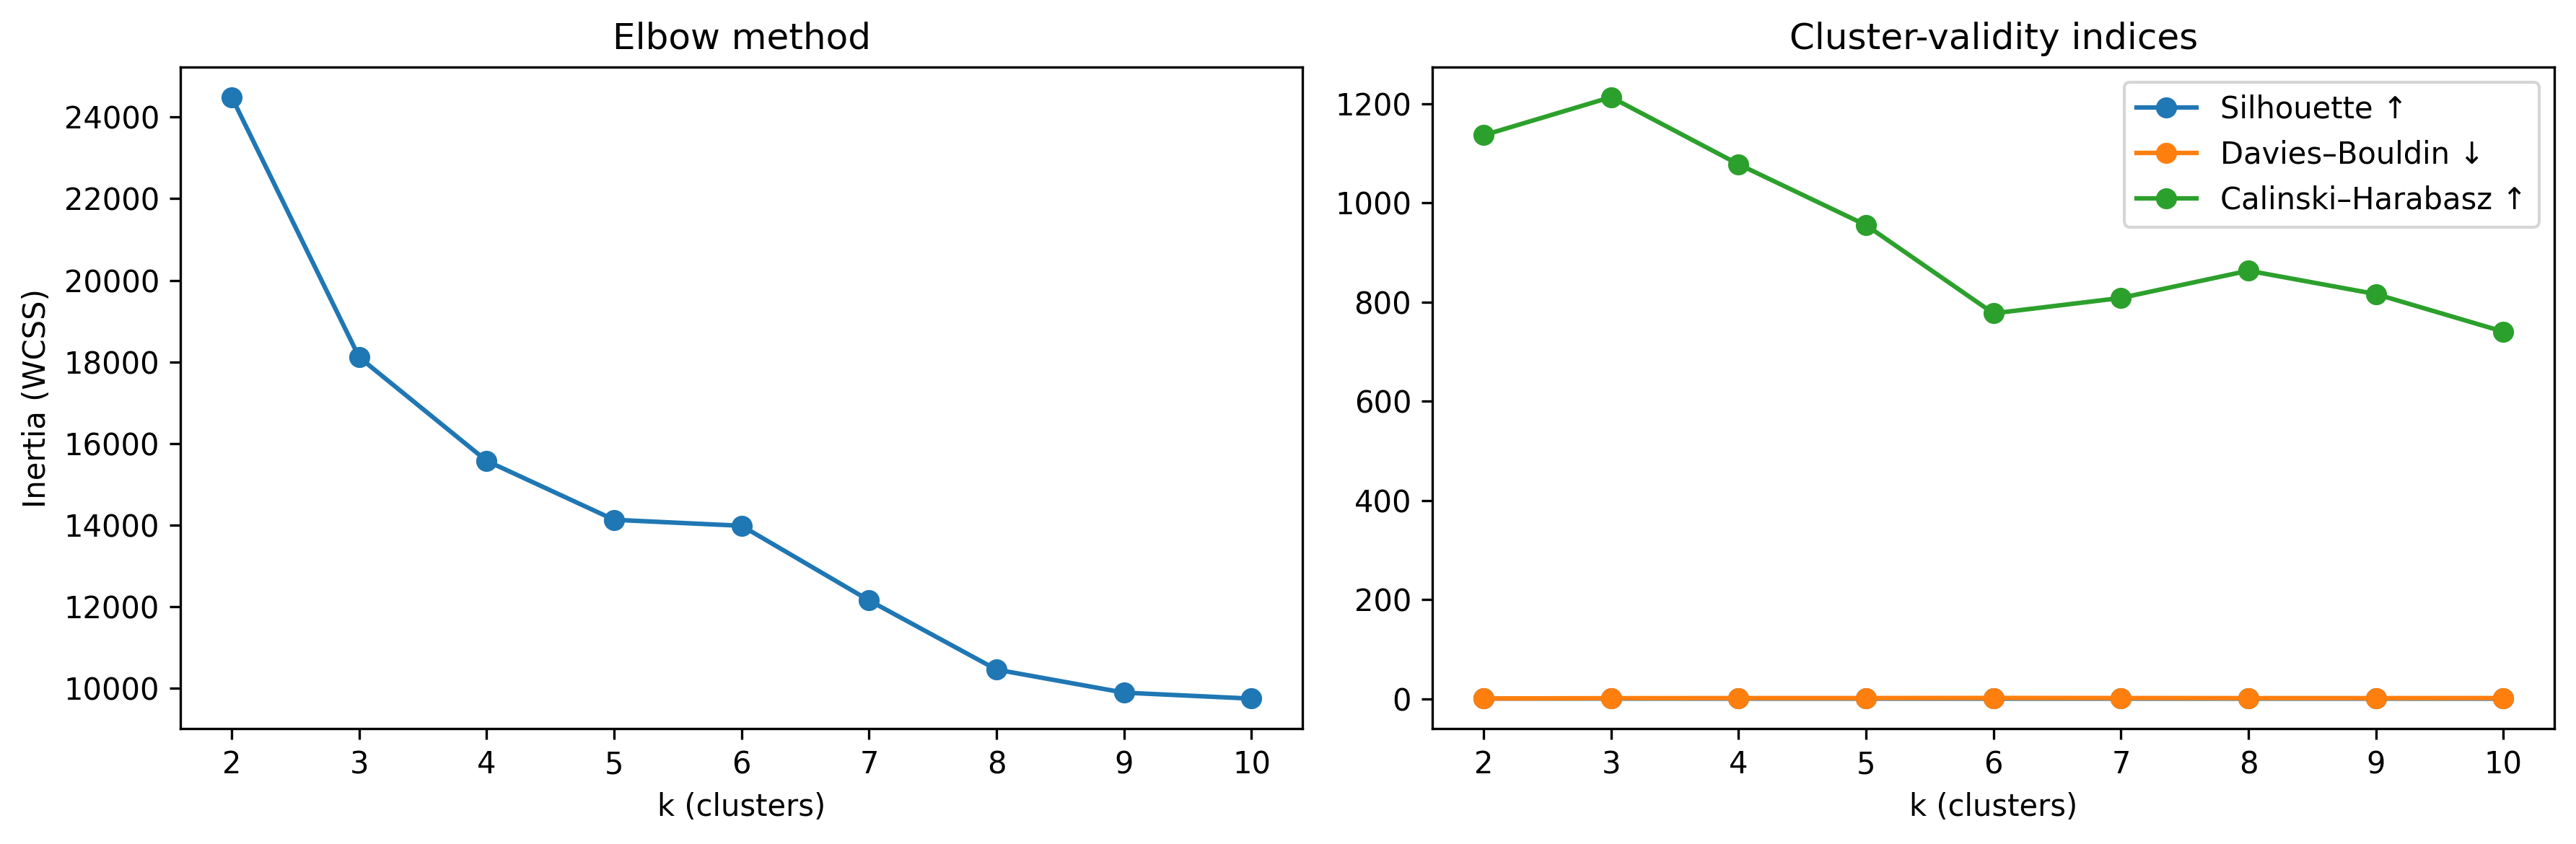

,k,inertia,silhouette,davies_bouldin,calinski_harabasz
0,2,24487.019836,0.567626,0.561799,1136.279464
1,3,18113.360620,0.323346,1.113283,1213.057466
2,4,15573.777886,0.312550,1.309326,1077.738599
3,5,14130.147582,0.283505,1.341564,955.114949
7,9,9894.428930,0.274834,1.247715,816.033288
6,8,10458.801158,0.270735,1.232154,863.161538
5,7,12153.917345,0.261101,1.425589,808.174314
4,6,13983.328016,0.256730,1.605868,777.117932
8,10,9747.609364,0.250140,1.413670,740.220904


In [7]:
def kmeans_diagnostics(
        features_df,
        k_range=range(2, 11),
        scaler=None,
        random_state=0
    ):
    """
    Runs KMeans for each k in k_range, computes cluster-validity metrics,
    makes diagnostic plots, and returns a DataFrame of the results.
    """
    X = features_df.select_dtypes('number').copy()
    
    scaler = scaler or StandardScaler()
    X_scaled = scaler.fit_transform(X)

    inertias, sils, dbs, chs = [], [], [], []

    for k in k_range:
        km = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
        labels = km.fit_predict(X_scaled)

        inertias.append(km.inertia_)
        sils.append(silhouette_score(X_scaled, labels))
        dbs.append(davies_bouldin_score(X_scaled, labels))
        chs.append(calinski_harabasz_score(X_scaled, labels))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].plot(k_range, inertias, "o-")
    axes[0].set(
        xlabel="k (clusters)",
        ylabel="Inertia (WCSS)",
        title="Elbow method"
    )
    
    axes[1].plot(k_range, sils, "o-", label="Silhouette ↑")
    axes[1].plot(k_range, dbs,  "o-", label="Davies–Bouldin ↓")
    axes[1].plot(k_range, chs,  "o-", label="Calinski–Harabasz ↑")
    axes[1].set(
        xlabel="k (clusters)",
        title="Cluster-validity indices"
    )
    axes[1].legend()
    plt.tight_layout()
    plt.show()

    metrics = pd.DataFrame({
        "k": list(k_range),
        "inertia": inertias,
        "silhouette": sils,
        "davies_bouldin": dbs,
        "calinski_harabasz": chs
    })
    return metrics

metrics = kmeans_diagnostics(
    features_df,
    k_range=range(2, 11), 
    random_state=42
)

display(metrics.sort_values("silhouette", ascending=False))

Due to the above metrics, we use k=3 for the algorithm

In [8]:
k=3
kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(X_scaled)
df_condensed["cluster"] = kmeans.labels_
df_condensed.head(3)

,Area (m²),Area of basin,Percentage Protected Land (of total bofedal),Average Elevation (m),Elevation Standard Deviation (m),Number of wells (per catchment area),Precipitation (mm),PET (mm),Maximum Temperature (°C),Minimum Temperature (°C),Surface Water Rights (L/s),Ground Water Rights (L/s),NDWI,NDVI,cluster
0,6300,86.769539,0.0,4162.714286,3.953815,0.0,15.011753,76.43679,9.74673,-5.034592,1715.5,2424.3,-0.003601,0.218041,1
1,5400,83.176353,0.0,4073.500000,12.406316,0.0,15.011753,76.43679,9.74673,-5.034592,1715.5,2424.3,-0.046695,0.205608,1
2,6300,103.719438,0.0,4278.571429,6.161102,0.0,15.011753,76.43679,9.74673,-5.034592,1715.5,2424.3,0.035979,0.180369,1


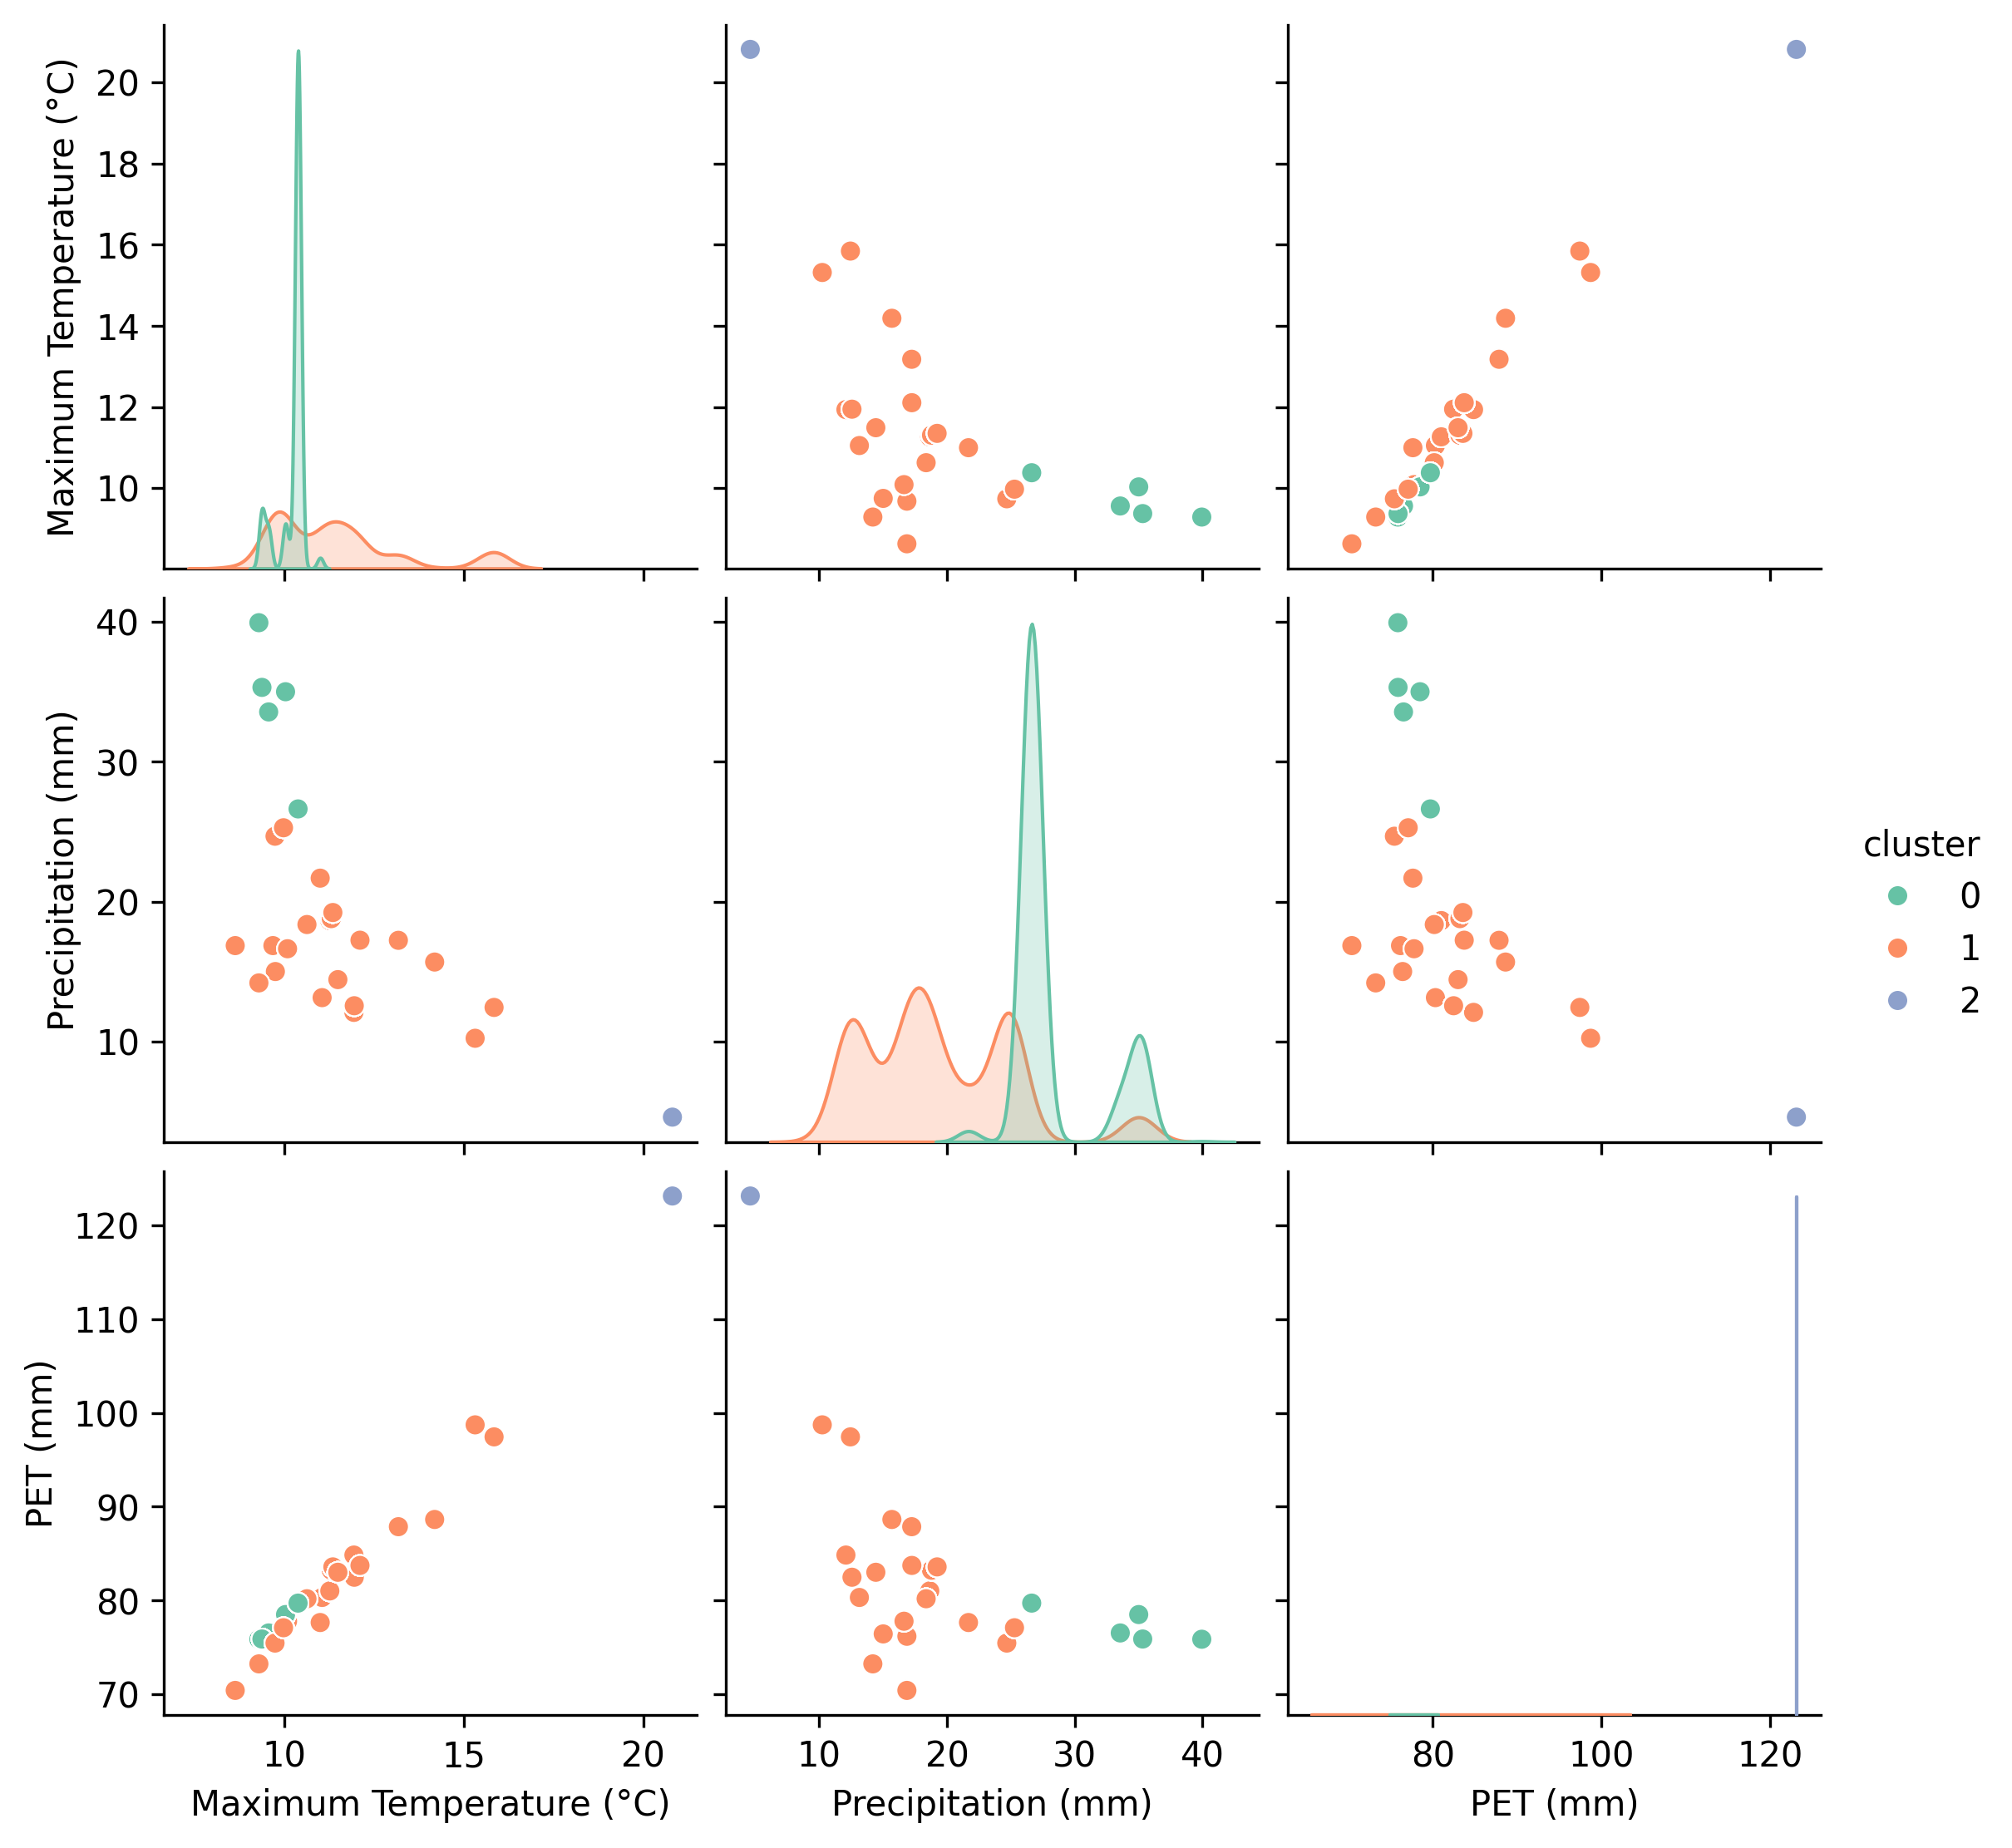


Centroid means (k = 3):


,0,1,2
Area (m²),-0.002319,0.013485,-0.094332
Area of basin,-0.351732,0.279181,0.028752
Percentage Protected Land (of total bofedal),0.931268,-0.680084,-0.555803
Average Elevation (m),0.495675,-0.304058,-0.766003
Elevation Standard Deviation (m),-0.110698,0.100587,-0.094223
Number of wells (per catchment area),-0.266041,-0.254487,3.801576
Precipitation (mm),0.786080,-0.356371,-2.236167
PET (mm),-0.371031,-0.126565,3.448225
Maximum Temperature (°C),-0.461297,-0.032838,3.276376
Minimum Temperature (°C),-0.807797,0.357518,2.368550


In [9]:
sns.pairplot(
    df_condensed.assign(cluster=kmeans.labels_),
    vars=["Maximum Temperature (°C)", "Precipitation (mm)", "PET (mm)"],
    hue="cluster", palette="Set2"
); plt.show()

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=features_df.columns)
print("\nCentroid means (k = 3):")
display(centroids.T)

#### Results
- Cluster 0: Cool & wet bofedales
- Cluster 1: Moderate sites balancing both factors
- Cluster 2: Hot & extremely dry outliers

In [10]:
df_condensed["lat"] = pd.read_csv("bofedales-clean.csv")["lat"]
df_condensed["lon"] = pd.read_csv("bofedales-clean.csv")["lon"]
df = df_condensed

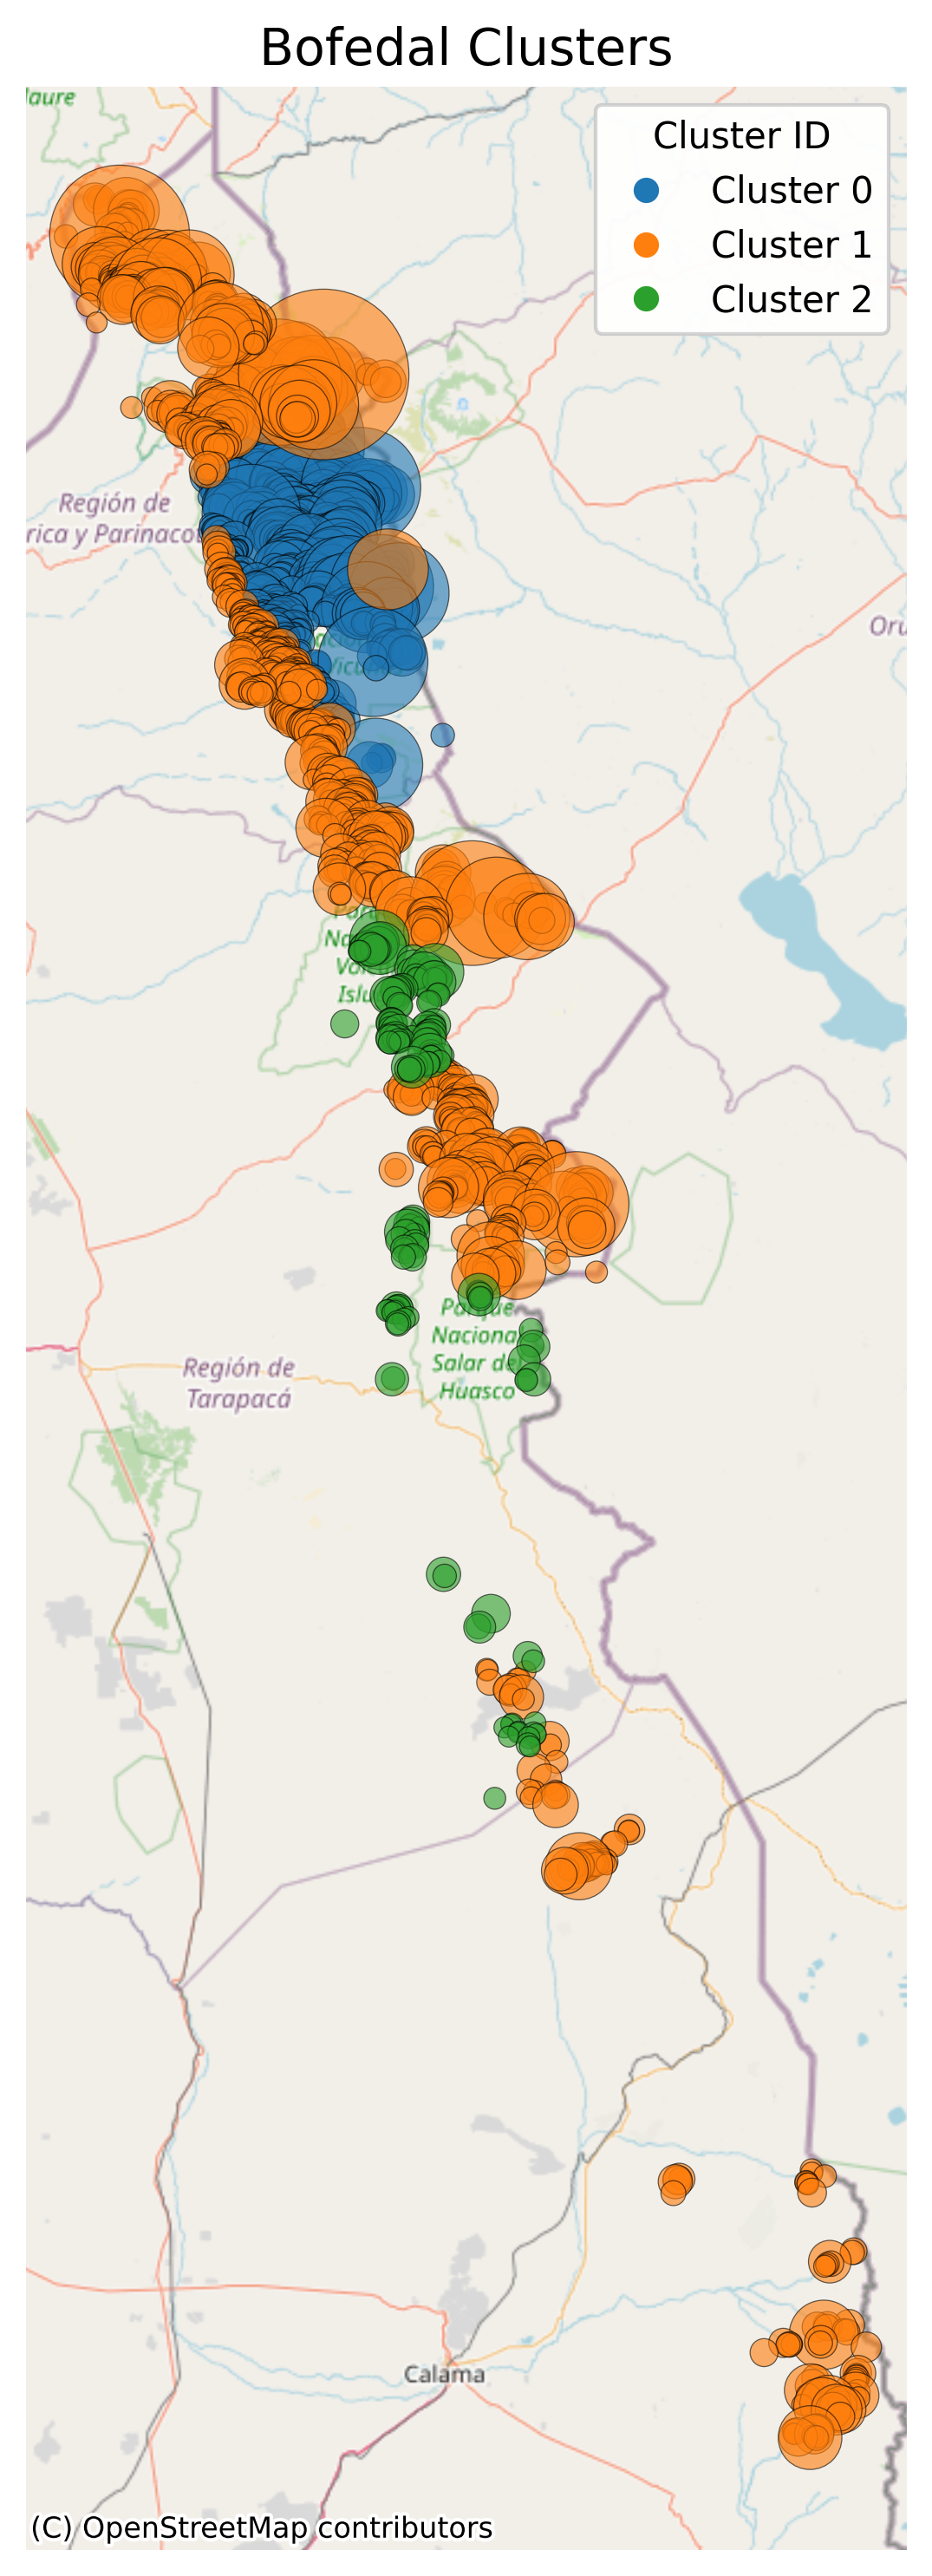

In [11]:
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]

gdf = gpd.GeoDataFrame(
    df.copy(), 
    geometry=geometry,
    crs="EPSG:4326"
)

gdf["size_for_plot"] = gdf["Area (m²)"].apply(lambda a: (a**0.5))

scale_factor = 0.5
gdf["size_for_plot"] *= scale_factor

gdf_3857 = gdf.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(8, 10))

cmap = plt.get_cmap("tab10")

for i, cluster_id in enumerate(sorted(gdf_3857["cluster"].unique())):
    subset = gdf_3857[gdf_3857["cluster"] == cluster_id]
    
    ax.scatter(
        subset.geometry.x,
        subset.geometry.y,
        s=subset["size_for_plot"],
        c=[cmap(i)],
        alpha=0.6,
        edgecolor="k",
        linewidth=0.3,
        label=f"Cluster {cluster_id}"
    )

ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
)

cluster_handles = []
for idx, cluster_id in enumerate(sorted(gdf_3857["cluster"].unique())):
    cluster_handles.append(
        Line2D(
            [], [], 
            marker="o", 
            markersize=6, 
            color=cmap(idx),
            linestyle="",
            label=f"Cluster {cluster_id}",
        )
    )

legend1 = ax.legend(handles=cluster_handles, title="Cluster ID", loc="upper right")
ax.add_artist(legend1)

ax.set_aspect('equal', adjustable='box')

ax.set_axis_off()
ax.set_title("Bofedal Clusters", fontsize=14)
plt.tight_layout()
plt.show()

In [12]:
palette = [
    "indianred","lightsalmon","mediumaquamarine","powderblue","darkslateblue",
    "mediumturquoise","lavender","palevioletred","olivedrab","lightpink",
    "gold","mediumvioletred","lightcoral","tomato","sandybrown",
    "darkseagreen","lemonchiffon","darksalmon","darkred","firebrick",
    "oldlace","royalblue","mediumpurple","plum"
]

agg = (df_condensed
       .groupby("cluster")
       .mean()
       .reset_index())


def make_trace(var, colour):
    return go.Bar(
        x=agg["cluster"].astype(str),
        y=agg[var],
        marker=dict(color=colour, line=dict(color="black")),
        name=var
    )

vars_list = list(agg.columns[1:])
default_var = vars_list[0]

fig = go.Figure(make_trace(default_var, palette[0]))

buttons = []
for i, var in enumerate(vars_list):
    buttons.append(
        dict(
            label  = var,
            method = "update",
            args   = [
                {"y": [agg[var]],
                 "marker.color": [palette[i % len(palette)]]},
                {
                  "title": f"Average {var} per cluster",
                  "yaxis": {"title": {"text": var}}
                }
            ]
        )
    )

fig.update_layout(
    yaxis_title=default_var,
    xaxis=dict(title="Cluster", type="category"),
    updatemenus=[dict(
        type="dropdown",
        direction="down",
        showactive=True,
        buttons=buttons,
        x=0.0, xanchor="left",
        y=1.15, yanchor="top"
    )],
    margin=dict(t=90, r=20, l=60, b=50),
    height=450, width=700,
    showlegend=False
)

fig